In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from frontfixing import nielsen, company
import lcp
from option import PutAmericanOption
from sklearn.metrics import mean_absolute_error

# Front fixing method

In [3]:
r = 0.08
sigma = 0.2
T = 3
K = 100

put = PutAmericanOption(K, T)
S_test = [90,100,110,120]
V_test = [11.6974, 6.9320, 4.1550, 2.5102]

## Inverse transformation

### Explicit


In [4]:
dx = [1/32, 1/64, 1/128, 1/512]
dt = 0.5*(dx[-1])**2

result = np.empty((len(dx), len(S_test),))
for i, dx_i in enumerate(dx):
    V, S_bar = nielsen.solve_explicitly(put, r, sigma, 2, dx_i, dt)
    V_pred = V(S_test)
    print(V_pred)
    result[i] = V_pred

[11.66260353  6.90244932  4.11780375  2.45127772]
[11.68636863  6.91736523  4.12879964  2.46192898]
[11.69238008  6.92135051  4.13216216  2.46584723]
[11.69435998  6.92286998  4.13382877  2.46825368]


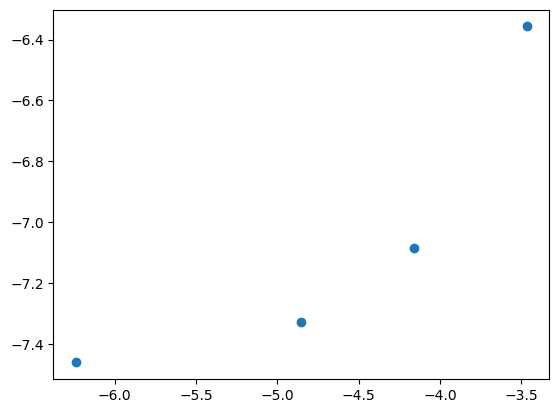

In [5]:
log_dx = np.log(dx)
result_df = pd.DataFrame(result, index=dx, columns=S_test)
error_df = (result_df - V_test).pow(2).mean(axis=1)
log_error_df = np.log(error_df)
log_error_df
# p = np.polyfit(log_dx, log_error_df, deg=1)
# f = np.poly1d(p)
plt.scatter(log_dx, log_error_df)
# plt.plot(f(np.linspace(np.min(log_dx), np.max(log_dx))))
plt.show()

### Implicit

In [6]:

dx = [1/8, 1/16, 1/32, 1/64, 1/128, 1/256, 1/512, 1/1024 ]
dt = 1e-3


result = np.empty((len(S_test), len(dx)))
for i, dx_i in enumerate(dx):
    V, S_bar = nielsen.solve_implicitly(put, r, sigma, 3, dx_i, dt)
    V_pred = V(S_test)
    print(V_pred)
    result[i] = V_pred

Start time: 2023-08-18 10:46:48.851821
Final time: 2023-08-18 10:48:54.319222


ValueError: A value (120.0) in x_new is above the interpolation range's maximum value (119.88082484085486).

In [ ]:
log_dx = np.log(dx)
result_df = pd.DataFrame(result, index=dx, columns=S_test)
error_df = (result_df - V_test).pow(2).mean(axis=1)
log_error_df = np.log(error_df)
log_error_df
# p = np.polyfit(log_dx, log_error_df, deg=1)
# f = np.poly1d(p)
plt.scatter(log_dx, log_error_df)
# plt.plot(f(np.linspace(np.min(log_dx), np.max(log_dx))))
plt.show()

## Log transformation

## Explicit

In [ ]:
dx = [0.04, 0.02, 0.01]
dt = 2e-3

result = np.empty((len(dx), len(S_test),))
for i, dx_i in enumerate(dx):
    V, S_bar = company.solve_explicitly(put, r, sigma, 8, dx_i, dt)
    S = np.linspace(0, 150, num=200)
    V_pred = V(S_test)
    result[i] = V_pred

result

In [ ]:
log_dx = np.log(dx)
result_df = pd.DataFrame(result, index=dx, columns=S_test)
error_df = (result_df - V_test).abs()
log_error_df = np.log(error_df.mean(axis=1))

p = np.polyfit(log_dx, log_error_df, deg=1)
f = np.poly1d(p)
plt.scatter(log_dx, log_error_df)
# plt.plot(f(np.linspace(np.min(log_dx), np.max(log_dx))))
plt.show()

# LCP + PSOR

## Explicit

In [ ]:
dx = [1/32, 1/64, 1/128, 1/512]
dt = 0.5*(dx[-1])**2

result = np.empty((len(dx), len(S_test),))
for i, dx_i in enumerate(dx):
    V, S_bar = lcp.solve(put, r, sigma, 2, dx_i, dt)
    V_pred = V(S_test)
    print(V_pred)
    result[i] = V_pred

## Implicit

In [ ]:
dx = [1/32, 1/64, 1/128, 1/512]
dt = 0.5*(dx[-1])**2

result = np.empty((len(dx), len(S_test),))
for i, dx_i in enumerate(dx):
    V, S_bar = lcp.solve(put, r, sigma, 2, dx_i, dt)
    V_pred = V(S_test)
    print(V_pred)
    result[i] = V_pred